Ouvrir ce notebook dans :
<a href="https://colab.research.google.com/github/joanglaunes/deep_learning_image/blob/main/TP_U-Net.ipynb" target="_blank">Google Colab</a>
ou
<a href="https://rosenblatt.ens.math-info.univ-paris5.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjoanglaunes%2Fdeep_learning_image&urlpath=tree%2Fdeep_learning_image%2FTP_U-Net.ipynb&branch=main" target="_blank">Rosenblatt</a>

U-Net : réseau convolutionnel pour la segmentation
==================================================

Dans ce notebook on implémente un réseau U-Net classique que l'on entraîne pour une tache de segmentation.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time, copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Définition du réseau
--------------------

Le réseau est basé sur une architecture classique de type auto-encodeur, auquel on ajoute des skip-connections par concaténation pour récupérer une information de localisation spatiale.

In [4]:
class UNet(nn.Module):

    @staticmethod
    def block(in_channels, features):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
                ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
                ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            )

    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder1 = UNet.block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet.block(32, 64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet.block(64, 128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet.block(128, 256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet.block(256, 512)

        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder4 = UNet.block(512, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = UNet.block(256, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = UNet.block(128, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = UNet.block(64, 32)

        self.conv = nn.Conv2d(in_channels=32,
                              out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

Chargement du jeu de données
----------------------------

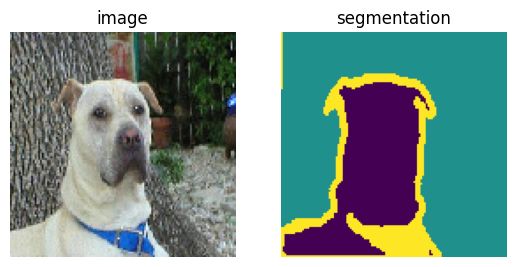

In [45]:
import numpy as np
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms.v2 as transforms
from torchvision import datasets
from torchvision.transforms import InterpolationMode

batch_size = 64
class_names = ['pet', 'background', 'outline']

train_transform = transforms.Compose([
    transforms.Resize((128,128), interpolation=InterpolationMode.NEAREST),
    transforms.RandomHorizontalFlip(),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

train_val_dataset = OxfordIIITPet(
    root = "data/OxfordPet", 
    split = 'trainval', 
    target_types = 'segmentation', 
    transforms = train_transform, 
    download = True)

train_val_dataset = datasets.wrap_dataset_for_transforms_v2(train_val_dataset)

train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [0.8, 0.2])

test_transform = transforms.Compose([
    transforms.Resize((128,128), interpolation=InterpolationMode.NEAREST),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

test_dataset = OxfordIIITPet(
    root = "data/OxfordPet", 
    split = 'test', 
    target_types = 'segmentation', 
    transforms = test_transform, 
    download = True)
test_dataset = datasets.wrap_dataset_for_transforms_v2(test_dataset)

dataset_sizes = {"train":len(train_dataset), "val":len(val_dataset)}

dataloaders = {"train": torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
               "val": torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
               "test": torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
              }

def imshow(image, title=None):
    if len(image.shape)==2:
      image = torch.tile(image[None,:,:],(3,1,1))
    image = image.permute((1, 2, 0))
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)

img, smnt = test_dataset[205]
plt.subplot(1,2,1); imshow(img); plt.title("image")
plt.subplot(1,2,2); imshow(smnt); plt.title("segmentation");

Encodage One-Hot:
-----------------

Dans ce jeu de données les segmentations sont fournies sous la forme d'images à un canal avec trois valeurs $1,2,3$ correspondant aux trois classes. Un batch de segmentations est donc un tableau de taille $(B,1,H,W)$ où chaque valeur est dans $\{1,2,3\}$. Pour pouvoir utiliser les loss classiques de segmentation, on va convertir en des batchs de la forme $(B,3,H,W)$, avec donc trois valeurs pour chaque pixel, correspondant aux probabilités d'appartenance à chacune des classes. Ceci s'obtient par encodage "one-hot":

In [1]:
def batch_one_hot(x):
    return F.one_hot(x.long()[:,0,:,:]-1).permute((0,3,1,2)).float()

# on aura également besoin de la conversion inverse:
def batch_inv_one_hot(x):
    return torch.argmax(x,dim=1)[:,None,:,:]+1

Entraînement du réseau
----------------------

On écrit une fonction classique pour l'entraînement:

In [47]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = torch.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, segs in dataloaders[phase]:
                inputs = inputs.to(device)
                segs = segs.to(device)
                segs = batch_one_hot(segs)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, segs)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Puis on effectue l'entraînement. Le loss est l'entropie croisée, comme dans le cas de la classification, mais du fait du format des sorties $(B,3,H,W)$, PyTorch applique l'opération par pixel.

In [48]:
num_epochs = 20

model = UNet(in_channels=3, out_channels=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=.1)

model = train_model(model, criterion, optimizer, scheduler=scheduler, num_epochs=num_epochs)

Epoch 0/19
----------
train Loss: 0.8661
val Loss: 0.8757

Epoch 1/19
----------
train Loss: 0.7948
val Loss: 0.8151

Epoch 2/19
----------
train Loss: 0.7774
val Loss: 0.8491

Epoch 3/19
----------
train Loss: 0.7612
val Loss: 0.7739

Epoch 4/19
----------
train Loss: 0.7477
val Loss: 0.8141

Epoch 5/19
----------
train Loss: 0.7333
val Loss: 0.7828

Epoch 6/19
----------
train Loss: 0.7241
val Loss: 0.7529

Epoch 7/19
----------
train Loss: 0.7063
val Loss: 0.7064

Epoch 8/19
----------
train Loss: 0.7000
val Loss: 0.7033

Epoch 9/19
----------
train Loss: 0.6968
val Loss: 0.7035

Epoch 10/19
----------
train Loss: 0.6934
val Loss: 0.7005

Epoch 11/19
----------
train Loss: 0.6925
val Loss: 0.7001

Epoch 12/19
----------
train Loss: 0.6901
val Loss: 0.6949

Epoch 13/19
----------
train Loss: 0.6880
val Loss: 0.6947

Epoch 14/19
----------
train Loss: 0.6854
val Loss: 0.6924

Epoch 15/19
----------
train Loss: 0.6841
val Loss: 0.6913

Epoch 16/19
----------
train Loss: 0.6833
val Loss

Visualisation des résultats
---------------------------

In [49]:
def test_model(model, N=5):
    model.eval()
    inputs, segs = next(iter(dataloaders["test"]))
    results = model(inputs.to(device)).data.cpu()
    results = batch_inv_one_hot(results)
    plt.figure(figsize=(10,6))
    for k in range(N):
        plt.subplot(3,N,k+1); imshow(inputs[k]); plt.title("image")
        plt.subplot(3,N,N+k+1); imshow(segs[k]); plt.title("segmentation")
        plt.subplot(3,N,2*N+k+1); imshow(results[k]); plt.title("resultat")
    plt.show();

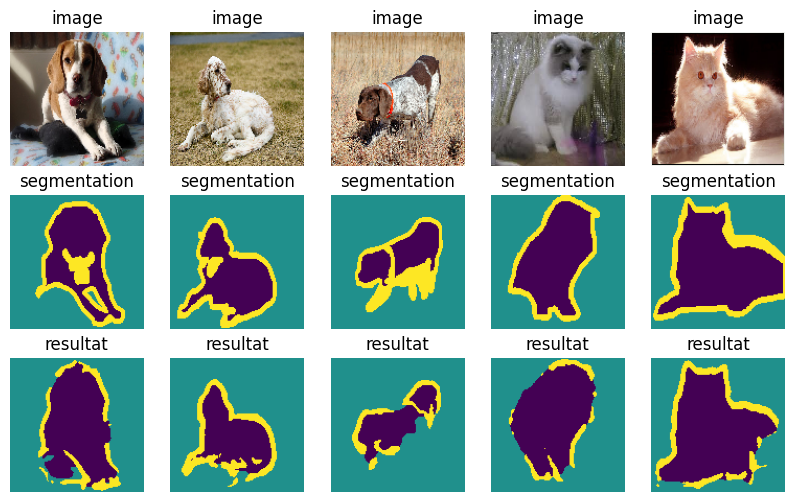

In [50]:
test_model(model)

__Question__ : Modifier le code de définition du U-Net pour ajouter la possibilité de supprimer les skip-connections, puis réentraîner le réseau sans skip-cconnections et comparer les résultats.